# Модель выделения коллекторов

## Содержание

* [Постановка задачи](#Постановка задачи)
* [Датасет](#Датасет)
* [Архитектура](#Архитектура)
* [Обучение](#Обучение)
* [Инференс](#Инференс)
* [Оценка модели](#Оценка-модели)
* [Краткое резюме](#Краткое-резюме)

## Постановка задачи

На основании каротажных данных выделить пропластки, являющиеся коллекторами.

## Датасет

Для обучения и оценки качества модели используются каротажи по скважинам месторождения "Крайнее".

Так как только один каротаж был измерен для всех скважин месторождения, был выделен набор каротажей, одновременно измеренных как минимум для 90% скважин. В него вошло 12 каротажей: CFTC, CILD, GR, GZ1, GZ2, GZ3, GZ4, GZ7, LLD, NKTD, PROX и SP. Этот набор каротажей был измерен для 321 скважины месторождения. Индикатор коллектора был получен из файлов с результатами интерпретации.

Полученный датасет был разбит на обучающую и тестовую выборки в соотношении 80:20.

In [1]:
import os
import sys
from copy import deepcopy
from functools import partial
sys.path.append(os.path.join("..", "..", ".."))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from well_logs import batchflow as bf
from well_logs import WellLogsDataset
from well_logs.batchflow.models.tf import UNet, VNet
from well_logs.batchflow.models.metrics import SegmentationMetricsByPixels

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [3]:
WELL_NPZ_PATH = "/notebooks/data/geolog/npz/*.npz"
ds = WellLogsDataset(path=WELL_NPZ_PATH, no_ext=True, sort=True)
ds.split(0.8, shuffle=True)

## Архитектура

Для решения задачи используется модель U-Net, общее описание ее архитектуры доступно по ссылке https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.unet.html

Модель обучается на кропах длины 256 из исходных каротажей.

Выбранная конфигурация модели:
* размерность входного слоя - [256, 12]
* размерность выходного слоя - [256, 1]
* количество фильтров в слоях энкодера и соответствующих им слоях декодера - [12, 12, 16, 16].

Задание конфигурации модели:

In [4]:
CROP_SIZE = 256

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8, allow_growth=True)
    
model_config = {
    "session": {"config": tf.ConfigProto(gpu_options=gpu_options)},
    "initial_block/inputs": "x",
    "head/num_classes": 1,
    "inputs": dict(x={"shape": (CROP_SIZE, 12)}, 
                   y={"name": "targets", "shape": (CROP_SIZE, 1)}),
    "body/filters": [12, 12, 16, 16],
    "body/encoder": dict(layout="cnacna", kernel_size=3),
    "body/decoder": dict(layout="cnacna", kernel_size=3),
    "body/upsample": dict(layout="tna", kernel_size=2, strides=2),
    "head": dict(layout="c"),
    "loss": "bce",
    "optimizer": "Adam",
    "output": ["sigmoid"],
}

## Обучение

Обучение происходит итерациями по батчам. Итерации состоят из:
* генерации очередной порции данных
* обновления весов нейронной сети.

Для обучения выбран оптимизатор Adam с параметрами по умолчанию:
* learning_rate = 0.001
* beta1 = 0.9
* beta2 = 0.999
* epsilon = 1e-08.

Функция потерь - бинарная кроссэнтропия.

Схема обхода датасета:
* размер батча - 32
* количество эпох - 200.

Описание пайплайна обучения:

In [5]:
N_EPOCH = 200
BATCH_SIZE = 32

In [6]:
def concatenate_batch(batch, model, concat_mask=True):
    feed_dict = {"x": np.concatenate(batch.logs).swapaxes(1, 2)}
    if concat_mask:
        feed_dict["y"] = np.concatenate(batch.mask).swapaxes(1, 2)
    return {"feed_dict": feed_dict}

In [7]:
template_train_ppl = (
    bf.Pipeline()
      .init_model("dynamic", UNet, name="unet", config=model_config)
      .init_variable("loss_history", init_on_each_run=list)
      .init_variable("pred", init_on_each_run=list)
      .load(fmt="npz")
      .drop_nans()
      .standardize()
      .random_split_logs(CROP_SIZE, 4, split_mask=True)
      .train_model("unet", make_data=concatenate_batch,
                   fetches=["loss", "sigmoid"],
                   save_to=[bf.V("loss_history"), bf.V("pred")],
                   mode="a")
      .run(batch_size=BATCH_SIZE, n_epochs=N_EPOCH, shuffle=True, drop_last=True,
           lazy=True, bar=True)
)

Запуск процедуры обучения:

In [8]:
train_ppl = (ds.train >> template_train_ppl)
train_ppl.run()

  0%|          | 0/1600 [00:00<?, ?it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


100%|██████████| 1600/1600 [10:26<00:00,  2.49it/s]


График функции потерь в зависимости от числа эпох:

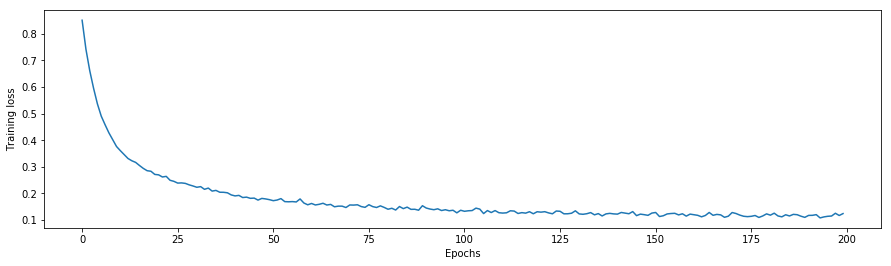

In [9]:
train_loss = [np.mean(l) for l in np.array_split(train_ppl.get_variable("loss_history"), N_EPOCH)]

fig = plt.figure(figsize=(15, 4))
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.show()

## Инференс

Описание вспомогательных функций:

In [10]:
def get_shapes(batch, logs):
    return [item.shape for item in logs]

def _copy(batch, x):
    return deepcopy(x)

def _concat(batch, x):
    return np.concatenate(x).swapaxes(1, 2)

Пайплайн для получения сегментации:

In [11]:
template_predict_ppl = (
    bf.Pipeline()
      .import_model("unet", train_ppl)
      .init_variable("shapes")
      .load(fmt="npz")
      .drop_nans()
      .standardize()
      .update_variable("shapes", bf.F(get_shapes, bf.B("logs")), mode="w")
      .split_logs(CROP_SIZE, CROP_SIZE)
      .predict_model("unet", make_data=partial(concatenate_batch, concat_mask=False),
                     fetches="sigmoid", save_to=bf.B("predictions"), mode="w")
      .split_predictions(CROP_SIZE, CROP_SIZE, bf.V("shapes"))
      .average_prediction(CROP_SIZE, CROP_SIZE, bf.V("shapes"))
      .run(batch_size=1, n_epochs=1, shuffle=False, drop_last=False, lazy=True)
)

Запуск сегментации:

In [12]:
predict_ppl = (ds.test >> template_predict_ppl)
batch = predict_ppl.next_batch()

Визуализация предсказания модели:

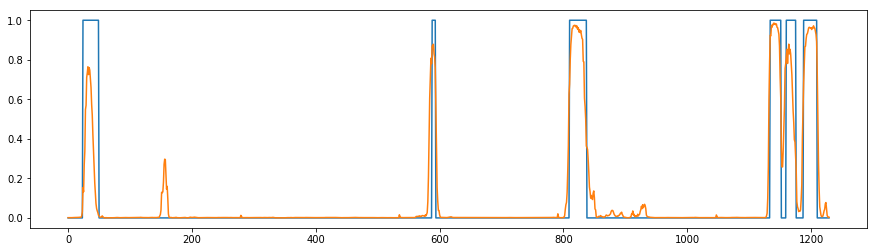

In [13]:
plt.figure(figsize=(15, 4))
plt.plot(batch.mask[0][1000:2230])
plt.plot(batch.predictions[0][0][1000:2230])
plt.show()

## Оценка модели

Качество модели определяется средним значением метрики F1-score по непересекающимся кропам из тестового набора данных.

Описание процедуры расчета метрики:

In [14]:
template_test_ppl = (
    bf.Pipeline()
      .import_model("unet", train_ppl)
      .init_variable("pred", init_on_each_run=list)
      .init_variable("shapes")
      .init_variable("metrics", init_on_each_run=None)
      .init_variable("target")
      .init_variable("mask")
      .load(fmt="npz")
      .drop_nans()
      .standardize()
      .update_variable("shapes", bf.F(get_shapes, bf.B("logs")), mode="w")
      .update_variable("target", bf.F(_copy, bf.B("mask")), mode="w")
      .split_logs(CROP_SIZE, CROP_SIZE, split_mask=True)
      .predict_model("unet", make_data=concatenate_batch, fetches="sigmoid",
                     save_to=bf.V("pred"), mode="w")
      .update_variable("mask", bf.F(_concat, bf.B("mask")), mode="w")
      .gather_metrics(SegmentationMetricsByPixels, targets=bf.V("mask"),
                      predictions=bf.V("pred"), fmt="proba",
                      save_to=bf.V("metrics"), mode="a")
      .run(batch_size=BATCH_SIZE, n_epochs=1, shuffle=False, drop_last=False,
           lazy=True, bar=True)
)

Запуск расчета метрики:

In [15]:
test_ppl = (ds.test >> template_test_ppl)
test_ppl.run()

 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]


In [16]:
metrics = test_ppl.get_variable("metrics")
metrics.evaluate("f1_score")

0.6809257261260147

## Краткое резюме

На основе каротажных данных месторождения "Крайнее" была обучена модель выявления коллекторов. Точность модели по метрике F1-score для класса "коллектор" по кропам исходных каротажей составила 0.68.